Mean Squared Error: 20.012469041016953
R-squared: -1.5748482225886309


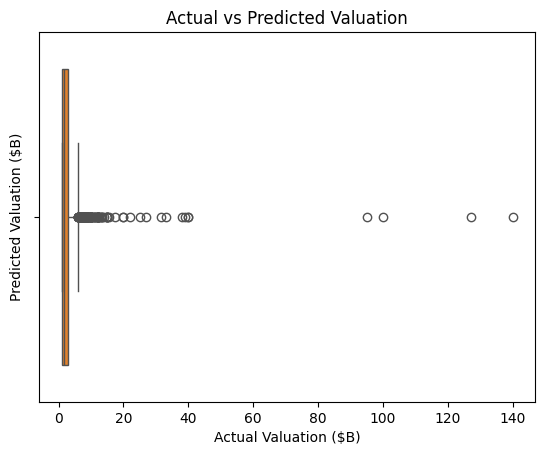

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv('../data/interim/unicorns_valuations_02.csv')

X = df.drop(columns=['Valuation ($B)'])
y = df['Valuation ($B)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestRegressor (n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Valuation ($B)')
plt.ylabel('Predicted Valuation ($B)')
plt.title('Actual vs Predicted Valuation')

sns.boxplot(x=df['Valuation ($B)'])
plt.show()

Removed 116 outliers
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Warning] Unknown parameter: model__n_estimators
[LightGBM] [Warning] Unknown parameter: model__num_leaves
[LightGBM] [Warning] Unknown parameter: model__learning_rate
[LightGBM] [Warning] Unknown parameter: model__reg_lambda
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] Unknown parameter: model__n_estimators
[LightGBM] [Warning] Unknown parameter: model__num_leaves
[LightGBM] [Warning] Unknown parameter: model__learning_rate
[LightGBM] [Warning] Unknown parameter: model__reg_lambda
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6081
[LightGBM] [Info] Number of data points in the train set: 680, number of used features: 33
[LightGBM] [Warning] Un

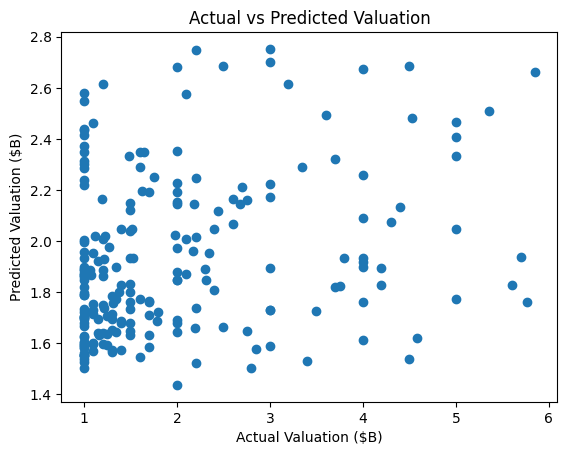

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin
import lightgbm as lgb

# Custom wrapper for LGBMRegressor to include early stopping
class LGBMRegressorWithEarlyStopping(BaseEstimator, RegressorMixin):
    def __init__(self, **params):
        self.model = lgb.LGBMRegressor(**params)
        self.early_stopping_rounds = params.get('early_stopping_rounds', 10)
        self.eval_metric = params.get('eval_metric', 'rmse')
    
    def fit(self, X, y, eval_set=None):
        self.model.fit(X, y,
                       eval_set=eval_set,
                       eval_metric=self.eval_metric,
                       early_stopping_rounds=self.early_stopping_rounds,
                       verbose=False)
        return self
    
    def predict(self, X):
        return self.model.predict(X)
    
    def get_params(self, deep=True):
        return self.model.get_params(deep=deep)
    
    def set_params(self, **params):
        self.model.set_params(**params)
        return self

df = pd.read_csv('../data/interim/unicorns_valuations_02.csv')

Q1 = df['Valuation ($B)'].quantile(0.25)
Q3 = df['Valuation ($B)'].quantile(0.75)
IQR = Q3 - Q1 #Interquartile Range

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Valuation ($B)'] < lower_bound) | (df['Valuation ($B)'] > upper_bound)]
df_cleaned = df[(df['Valuation ($B)'] >= lower_bound) & (df['Valuation ($B)'] <= upper_bound)]

print(f"Removed {len(outliers)} outliers")

X = df_cleaned.drop(columns=['Valuation ($B)'])
y = df_cleaned['Valuation ($B)']

label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False) #Polynomial Features
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lgb_model = lgb.LGBMRegressor(random_state=42, n_estimators=1000, reg_lambda=0.5, early_stopping_rounds=10)

param_grid = {
    'model__num_leaves': [31, 50],
    'model__learning_rate': [0.01, 0.05],
    'model__n_estimators': [100, 200],
    'model__reg_lambda': [0.1, 0.5]
}

grid_search=GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train, eval_set=[(X_test, y_test)])

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Best Hyperparameters: {grid_search.best_params_}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Valuation ($B)')
plt.ylabel('Predicted Valuation ($B)')
plt.title('Actual vs Predicted Valuation')
plt.show()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb

# Load and clean the data
df = pd.read_csv('../data/interim/unicorns_valuations_02.csv')

Q1 = df['Valuation ($B)'].quantile(0.25)
Q3 = df['Valuation ($B)'].quantile(0.75)
IQR = Q3 - Q1  # Interquartile Range

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Valuation ($B)'] < lower_bound) | (df['Valuation ($B)'] > upper_bound)]
df_cleaned = df[(df['Valuation ($B)'] >= lower_bound) & (df['Valuation ($B)'] <= upper_bound)]

print(f"Removed {len(outliers)} outliers")

# Prepare the data
X = df_cleaned.drop(columns=['Valuation ($B)'])
y = df_cleaned['Valuation ($B)']

# Encode categorical variables
label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

# Polynomial features (degree 2, full interactions)
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# LightGBM model without early stopping for grid search
lgb_model = lgb.LGBMRegressor(random_state=42)

param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.03, 0.05],
    'n_estimators': [200, 500, 1000],
    'reg_lambda': [0.1, 0.5, 1.0],
    'reg_alpha': [0.1, 0.5, 1.0],
    'feature_fraction': [0.8, 0.9, 1.0],
    'bagging_fraction': [0.8, 0.9, 1.0],
}

# Implementing Grid Search without early stopping
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Extracting the best model
best_params = grid_search.best_params_

# Now train the best model with early stopping
best_model = lgb.LGBMRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse', early_stopping_rounds=10, verbose=False)

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Best Hyperparameters: {best_params}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plot the results
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Valuation ($B)')
plt.ylabel('Predicted Valuation ($B)')
plt.title('Actual vs Predicted Valuation')
plt.show()

Removed 116 outliers
Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv('../data/interim/unicorns_valuations_02.csv')
df.head()
df.isnull().sum()
df.describe()
df.columns = df.columns.str.strip()
df['Date Joined'] = pd.to_datetime(df['Date Joined'])
df['Days Since Joined'] = (pd.to_datetime('today') - df['Date Joined']).dt.days

label_encoders = {}
categorical_columns = ['Country', 'Industry'] + [col for col in df.columns if 'Investor' in col]

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

df.drop(columns=['Date Joined', 'Company', 'City'], inplace=True)

df = pd.read_csv('../data/interim/unicorns_investors_01.csv')
df['Valuation ($B)'] = df['Valuation ($B)'].str.replace('$', '').astype(float)
df.head()
interim_path = '../data/interim/unicorns_valuations_02.csv'
df.to_csv(interim_path, index=False)